# MSDS 7331 - Lab Two: Regress or Classify

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=lab2)
- [Tom Elkins](telkins@smu.edu?subject=lab2)
- [Austin Kelly](ajkelly@smu.edu?subject=lab2)
- [Murali Parthasarathy](mparthasarathy@smu.edu?subject=lab2)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to build upon the predictive analysis that you already completed in the previous mini-project, adding additional modeling from new classification algorithms as well as more explanations that are inline with the CRISP-DM framework. You should use appropriate cross validation for all of your analysis (explain your chosen method of performance validation <i>in detail</i>). Try to use as much testing data as possible <i>in a realistic manner</i> (you should define what you think is realistic and why).</p>
    <p>This report is worth 20% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a single document. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
    <p>Report Sections:</p>
    <ol>
        <li>[Data Preparation](#data_preparation) <b>(15 points)</b></li>
        <li>[Modeling and Evaluation](#modeling_and_evaluation) <b>(70 points)</b></li>
        <li>[Deployment](#deployment) <b>(5 points)</b></li>
        <li>[Exceptional Work](#exceptional_work) <b>(10 points)</b></li>
    </ol>
</div>

<a id='data_preparation'></a>
## 1 - Data Preparation
<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Data Preparation (<b>15 points total</b>)</h3>
    <ul><li>[<b>10 points total</b>] [1.1 - Define and prepare your class variables](#define_and_prepare_class_variables). Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reductions, scaling, etc. Remove variables that are not needed/useful for the analysis.</li>
    <li>[<b>5 points total</b>] [1.2 - Describe the final dataset](#describe_final_dataset) that is used for classification/regression (include a description of any newly formed variables you created.)</li>
    </ul>
</div>

<a id='define_and_prepare_class_variables'></a>
### 1.1 - Define and Prepare Class Variables
The data set chosen for lab 2 is the 2015 Washington DC Metro Crime inspired from a Kaggle data set found at [Kaggle](https://www.kaggle.com/vinchinzu/dc-metro-crime-data). The data set was obtained by following the steps found on the [Using the Crime Map Application](http://mpdc.dc.gov/node/200622) page. This site allowed us to download data by political ward for all eight wards from 01/01/2015 to 12/31/2015 as CSV files. These individual ward files were then merged together into a single file for our use. This data set contains 36,493 entries and 18 attributes that are both continuous and discrete. This satisfies the data set requirement for a minimum of 30,000 entries and 10 attributes which are both continuous and discrete. Further definition of this data set will be discussed in the [Data Understanding](#data_understanding) section.

The data is supplimented with weather data that corresponds to the end date of the crime obtained from [Wunderground](http://wunderground.com) to see if weather is a predictor or crimes in DC.

![Ward Map](images/ANC_2012.jpg "Washington DC ANC") 
<p style='text-align: center;'>
Washington DC Advisory Neighborhood Map
</p>

The crime data is published by the Washington DC Metro police department daily (see below image) to provide their residents a clear picture of crime trends as they actually happen. The data is shared with its residents such as Advisory Neighborhood Commissions, see above, to help the police determine how to keep neighborhoods safe. The data is also analyzed to determine the effectiveness of current investments such as putting more officers on the streets, buying police more tools, and launching community partnerships, see [Washington DC Metro Police Department report](http://mpdc.dc.gov/publication/mpd-annual-report-2015) for more details.

![Ward Map](images/dc_2015_crime.tiff "Washington DC Year End Crime Data") 
<p style='text-align: center;'>
Washington DC Metro 2015 Year End Crime Data
</p>

### 1.1.1 - Load Data

In [1]:
# generic imports
import pandas as pd
import numpy as np
from __future__ import print_function

# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# scikit imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Read in the crime data from the CSV file
#df = pd.read_csv('data/DC_Crime_2015_Lab2.csv')
df = pd.read_csv('data/DC_Crime_2015_Lab2_Weather.csv')

In [2]:
# how is the data represented?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 33 columns):
REPORT_DAT              36489 non-null object
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null object
END_DATE                36489 non-null object
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int64
OFFENSE_Code          

### 1.1.2 - Attribute Details
Remove unnecessary attributes and add attributes that might help us predict an offense.

#### Attributes to Remove
The below table provides a description of attributes that will be removed because they provide little to no predictive power.

|Attribute|Description|Removal Reason|
|:------|:----------|:-------------|
|REPORT_DAT| The date/time the offense was *reported*| When the crime was report is not a predictor of a crime.|
|SHIFT| The duty shift that responded to the call.| This is an eight hour window that is too coarse grain.|
|OFFENSE| The category of crime committed.| This attribute is redundant with OFFENSE_Code. It will be stored off for its labels.|
|METHOD| A qualifier to the Offense that flags special considerations, such as the use of a gun| This attribute is redundant with OFFENSE_Code. It will be stored off for its labels.|
|DISTRICT| The police district.| This attribute was replaced earlier preprocessing to create DistrictID.|
|PSA| Police Service Area| This attribute was replaced earlier preprocessing to create PSA_ID.|
|WARD| The political Ward identifier.| WARD can be derived from NEIGHBORHOOD_CLUSTER which provides a smaller geographic resolution.|
|CENSUS_TRACT| Land management tract identifier.| This attribute is superceded by other geographical data.|
|VOTING_PRECINCT| Political subdivision| This attribute is superceded by other geographical data.|
|CCN| Criminal Complaint Number - unique to each report| An index for the crime report.|
|XBLOCK| Eastern coordinate of crime scene (meters)| This attribute is superceded by lattitude and longitude.|
|YBLOCK| Northern coordinate of crime scene (meters)| This attribute is superceded by lattitude and longitude.|
|START_DATE| The earliest the crime *might* have been committed.| END_DATE provides a more accurate time when considering unwitness crimes.|
|DistrictID| The police district.| Redundant with PSA_ID. DistrictID can be derived from PSA_ID.|
|SHIFT_Code| The duty shift that responded to the call.| This is an eight hour window that is too coarse grain.|
|METHOD_Code| A qualifier code to the Offense that flags special considerations, such as the use of a gun|This attribute will not be known until the crime is committed.|
|CRIME_TYPE| A grouping category of violent or property for offences.| It can be derived from offense codes.|
|AGE| The difference in end data and start date of the crime.| This attribute is unreliable due to the discrepency in start dates.|
|TIME_TO_REPORT| The time it took for the police to report the crime.| This attribue represents action after the crime.|

In [3]:
# save target description
target_desc = df.OFFENSE.copy()

print(target_desc.unique())

['THEFT/OTHER' 'THEFT F/AUTO' 'BURGLARY' 'ASSAULT W/DW' 'ROBBERY'
 'MOTOR VEHICLE THEFT' 'HOMICIDE' 'SEX ABUSE' 'ARSON']


In [4]:
# remove attributes
for attrib in ('REPORT_DAT', 'SHIFT', 'OFFENSE', 'METHOD', 'DISTRICT', 'PSA', 'WARD', 'CENSUS_TRACT', 
               'VOTING_PRECINCT', 'CCN', 'XBLOCK', 'YBLOCK', 'START_DATE', 'DistrictID', 'SHIFT_Code', 
               'METHOD_Code', 'CRIME_TYPE', 'AGE', 'TIME_TO_REPORT'):
    if attrib in df:
        del df[attrib]

#### Attributes to Keep
The below table provides a description of attributes that will remain for predicting crimes in DC.

|Attribute|Description|Role|
|:------|:----------------|:----:|
|ANC| Advisory Neighborhood Commission that is a geo-political grouping.| Feature|
|NEIGHBORHOOD_CLUSTER|Neighborhood identifier that subdivides police wards.| Feature|
|END_DATE| The latest the crime *might* have been committed. This attribute will be broken down into day of week, month of year, and hour of the day.| Features|
|PSA_ID| Police Service Area that breaks down WARDS differently than ANC and NEIGHBORHOOD_CLUSTER.| Feature|
|OFFENSE_Code| The category code of crime committed. This is our target attribute.| Target|
|Latitude| The angular distance of the crime North of the earth's equator| Feature|
|Longitude| The angular distance of the crime West of the meridian at Greenwich, England| Feature|
|Max_Temp| The maximum temperature for the END_DATE in Fahrenheit| Feature|
|Min_Temp| The minimum temperature for the END_DATE in Fahrenheit| Feature|
|Max_Humidity| The maximum humidity for the END_DATE in inches| Feature|
|Min_Humidity| The minimum humidity for the END_DATE in inches| Feature|
|Max_Pressure| The maximum sea level pressure for the END_DATE in inches| Feature|
|Min_Pressure| The minimum sea level pressure for the END_DATE in inches| Feature|
|Precipitation| The amount of percipitation for the END_DATE in inches| Feature|

#### Attributes to Add

The below table provides a description of attributes that will be added for predicting crimes in DC. Do these features help us predic a class of a crime?

|Attribute|Description|Role|
|:------|:----------------|:----:|
|CRIME_MONTH|The latest month the crime was comitted.| Feature|
|CRIME_DAY| The latest day the crime was committed.| Feature|
|CRIME_HOUR| The latest hour the crime was committed.| Feature|
|MOON_PHASE| The moon phase where 0: New Moon, 1: Waxing Crescent, 2: First Quarter, 3: Waxing Gibbous, 4: Full Moon, 5: Waning Gibbous, 6: Last Quarter, and 7: Waning Crescent. | Feature|

In [5]:
if 'END_DATE' in df:
    # convert START_DATE to datetime
    df.END_DATE = pd.to_datetime(df.END_DATE)

    # add the month of the crime
    df['CRIME_MONTH'] = df.END_DATE.map(lambda x: x.month)
    df.CRIME_MONTH = df.CRIME_MONTH.astype('int64')

    # add day of the month
    df['CRIME_DAY'] = df.END_DATE.map(lambda x:x.day)
    df.CRIME_DAY = df.CRIME_DAY.astype('int64')

    # add hour of the day
    df['CRIME_HOUR'] = df.END_DATE.map(lambda x:x.hour)
    df.CRIME_HOUR = df.CRIME_HOUR.astype('int64')

In [6]:
# calculate moon phase, http://en.wikipedia.org/wiki/Lunar_phase#Lunar_phase_calculation
import datetime, math
from decimal import *

def calculate_moon_phase(now=None): 
    '''
    Cacluates the phase of the moon giving a date.
    
    Args:
        now (datetime): The datetime to determine the phase of the moon.
    Returns:
        int: The moon phase where 0: New Moon, 1: Waxing Crescent, 2: First Quarter, 3: Waxing Gibbous, 
        4: Full Moon, 5: Waning Gibbous, 6: Last Quarter, and 7: Waning Crescent
    '''
    if now is None: 
        now = datetime.datetime.now()

    diff = now - datetime.datetime(2001, 1, 1)
    days = Decimal(diff.days) + (Decimal(diff.seconds) / Decimal(86400))
    lunations = Decimal("0.20439731") + (days * Decimal("0.03386319269"))
    pos = lunations % 1
 
    index = (pos * Decimal(8)) + Decimal("0.5")
    return int(math.floor(index))

In [7]:
if 'END_DATE' in df:
    # add moon phase attribute
    df['MOON_PHASE'] = df.END_DATE.map(lambda x: calculate_moon_phase(x))
    df.MOON_PHASE = df.MOON_PHASE.astype('int64')
    
    # no longer need it
    del df['END_DATE']

#### One Hot Encode Category Data

All categorical data are ordinal or continuous so one-hot encoded is not required.

#### Attribute Representation
All attributes are properly represented.

In [8]:
# view attribute representation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 17 columns):
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
PSA_ID                  36489 non-null int64
OFFENSE_Code            36489 non-null int64
Latitude                36489 non-null float64
Longitude               36489 non-null float64
Max_Temp                36489 non-null int64
Min_Temp                36489 non-null int64
Max_Humidity            36489 non-null int64
Min_Humidity            36489 non-null int64
Max_Pressure            36489 non-null float64
Min_Pressure            36489 non-null float64
Precipitation           36489 non-null float64
CRIME_MONTH             36489 non-null int64
CRIME_DAY               36489 non-null int64
CRIME_HOUR              36489 non-null int64
MOON_PHASE              36489 non-null int64
dtypes: float64(5), int64(12)
memory usage: 4.7 MB


#### Example record

In [9]:
df.ix[1234]

ANC                      11.000000
NEIGHBORHOOD_CLUSTER      2.000000
PSA_ID                  302.000000
OFFENSE_Code              1.000000
Latitude                 38.932137
Longitude               -77.022559
Max_Temp                 86.000000
Min_Temp                 70.000000
Max_Humidity             82.000000
Min_Humidity             40.000000
Max_Pressure             30.090000
Min_Pressure             29.960000
Precipitation             0.000000
CRIME_MONTH               6.000000
CRIME_DAY                24.000000
CRIME_HOUR               21.000000
MOON_PHASE                2.000000
Name: 1234, dtype: float64

#### Setup Features [X] and Target [y]

In [10]:
if 'OFFENSE_Code' in df:
    target_codes = df['OFFENSE_Code'].copy() # save off old codes
    y = df['OFFENSE_Code'].values
    del df['OFFENSE_Code']
    X = df.values 

#### Size of Dataset and Target Details

Size of the dataset: (36489, 16)
Number of unique classes: 9
['THEFT/OTHER' 'THEFT F/AUTO' 'BURGLARY' 'ASSAULT W/DW' 'ROBBERY'
 'MOTOR VEHICLE THEFT' 'HOMICIDE' 'SEX ABUSE' 'ARSON']


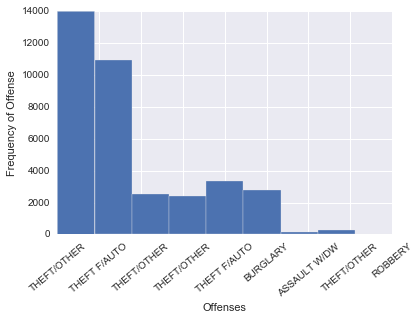

In [11]:
print('Size of the dataset:', df.shape)
print('Number of unique classes:', len(target_codes.unique()))
print(target_desc.unique())

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xticklabels(target_desc, rotation=40)
plt.hist(y, bins=len(target_codes.unique()))
plt.xlabel('Offenses')
plt.ylabel('Frequency of Offense')
plt.show()

#### Normalize 

Our data has different scales so it will require normalization. We will normalize our data on the training data. This is because we don't want to find out our mean and standard deviation from the testing data. This would be snooping.

In [54]:
from sklearn.preprocessing import StandardScaler

# create stratified k-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=0)

scaler = StandardScaler()
for train, test in skf.split(X, y):
    scaler.fit(X[train])
    break # only need one

# we now have a scaler to use to transform our data
# scaler.transform(...)

<a id='describe_final_dataset'></a>
### 1.2 - Purpose of Data Set
From data exploration in Lab 1 and the Mini-Lab, we have two potential response variables: Crime_Type (Property crime vs. Violent crime), and Offense_Code (The more specific type of offense: Homicide, Robbery, Theft, Arson, etc.). The goal is to provide the police with a model that can predict or classify a crime based on the available explanatory variables.

One problem with this data is that the victim profile data is missing (due to privacy concerns, and the fact that property crimes are not necessarily because of the owner's profile). The explanatory variables for this dataset focus on time and locations. We believe that the detection/classification of a Violent crime would be based primarily on the victim's characteristics, and not exclusively on the location or time. The other problem with this data is that (fortunately) there are far fewer violent crimes than there are property crimes (approximately 83% of the 36000+ crime reports are against property rather than persons), so we have very unbalanced classification tasks.

Our exploration of the variables seem to indicate that time (not necessarily the day, but the time during the day) is one of the more significant factors. We saw this in the SHIFT variable (which gives the Police duty shift that responded to the call). When we broke the time down into individual hours of the day, we saw a pronounced cyclic effect, where night-time crimes were far more likely than daytime crimes. Weekend crimes were slightly more likely than crimes during the work week, and monthly trends appeared to be opposite intuition (fall crimes were more likely than winter or summer crimes).

Location also appeared to have some influence, but the way the locations were grouped altered the effect significantly. Different political areas (Wards and the subordinate Association Neighborhood Committees) showed a different trend than using global locations (Latitude and Longitude). Police districts (and their subordinate Police Service Areas) showed a different trend than the Ward/ANC grouping. This tells us that there are some location effects, but it is difficult to separate them out due to the correlation between geo-physical areas and the different (but overlapping) political mappings.

From what we can tell, due to our previous exploration, the existing variables are not able to properly perform the classification tasks alone. As such, we have looked at including other data to attempt to fill in the picture more completely. As mentioned before, victim profile would be interesting and probably very helpful, but we would not be able to get access to that due to privacy concerns. We are examining environmental data (primarily weather data, but we also have access to lunar phases to estimate luminance for night crimes or the psychological impact of lunacy.
For these reasons, we have decided to drop the Crime_Type (Property vs. Violent crime) classification and focus on the Offense_Code (type of offense) classification task.

<a id="modeling_and_evaluation"></a>
## 2 - Modeling and Evaluation

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Modeling and Evaluation (<b>70 points total</b>)</h3>
    <ul><li>[<b>10 points</b>] [2.1 - Choose and explain your evaluation metrics](#choose_and_explain) that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</li>
    <li>[<b>10 points</b>] [2.2 - Choose the method you will use for dividing your data](#choose_the_method) into training and testing splits (i.e., are you Stratified 10-fold cross validataion? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</li>
    <li>[<b>20 points</b>] [2.3 - Create three different classification/regression models](#create_models) for each task (e.g., random forest KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</li>
    <li>[<b>10 points</b>] [2.4 - Analyze the results using your chosen method of evaluation](#analyze_results). Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</li>
    <li>[<b>10 points</b>] [2.5 - Discuss the advantages of each model](#discuss_models) for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques - be sure they are appropriate for your chosen method of validation.</li>
    <li>[<b>10 points</b>] [2.6 - Which attributes from your analysis are most important](#important_attributes)? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesis about why certain attributes are more important than others for a given classification task.</li>
   </ul>
</div>



<a id='choose_and_explain'></a>
### 2.1 - Choose and explain your evaluation metrics
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions. **(10 points total)**

<a id='choose_the_method'></a>
### 2.2 - Choose the method you will use for dividing your data
Choose the method you will use for dividing your data into training and testing splits (i.e., are you Stratified 10-fold cross validataion? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. **(10 points total)**

#### Answer
A simple train/test split provides a split of the data preferrably random into a buckets to train a model and then test it. With this approach only one model is trained and tested. If we have unbalanced classes like our dataset, then we might end up with a training model with a poor representation of our dataset. Or, the test dataset might not have enough class representation to assess the model.

A cross validation (CV) approach is more preferred for us to ensure each record is in the training and testing dataset exactly once. CV will split the data into folds where each fold is the test data, and the remaining folds are used to train the model. If we use a 10-fold cross validation, then we can use 9/10 of the data to train the model often resulting in a more accurate model.

Finally, we need to account for our unabalanced traget class as depicted in an earlier histogram. Therefore, we are using a 10-fold stratified cross validation strategy. A stratified CV will ensure each fold has the same target class frequency as the entire dataset. The histogram plots below illustrate this discussion.

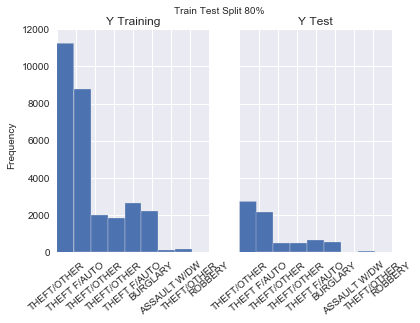

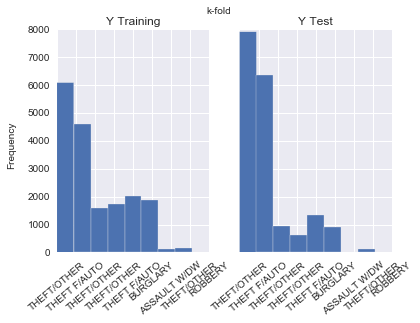

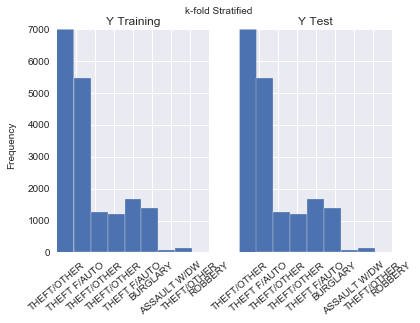

In [56]:
def plot_class_dist(train, test, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.hist(train, bins=len(target_codes.unique()))
    ax1.set_title('Y Training')
    ax1.set_xticklabels(target_desc, rotation=40)
    ax2.hist(test, bins=len(target_codes.unique()))
    ax2.set_title('Y Test')
    ax2.set_xticklabels(target_desc, rotation=40)
    fig.suptitle(title)
    fig.text(.01, .5, 'Frequency', va='center', rotation='vertical')
    plt.show()    
    
# train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
plot_class_dist(y_train, y_test, 'Train Test Split 80%')

# k-fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, random_state=0)
for train_idx, test_idx in kf.split(X, y):  
    plot_class_dist(y[train_idx], y[test_idx], 'k-fold')
    break # only plot one
    
# stratified k-fold
    skf = StratifiedKFold(n_splits=2, random_state=0)
for train_idx, test_idx in skf.split(X, y):  
    plot_class_dist(y[train_idx], y[test_idx], 'k-fold Stratified')
    break # only plot one

<a id='create_models'></a>
### 2.3 - Create three different classification/regression models
Create three different classification/regression models for each task (e.g., random forest KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! **(20 points total)**

<a id='analyze_results'></a>
### 2.4 - Analyze the results using your chosen method of evaluation
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model. **(10 points total)**

<a id='discuss_models'></a>
### 2.5 - Discuss the advantages of each model
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques - be sure they are appropriate for your chosen method of validation. **(10 points total)**

<a id='important_attributes'></a>
### 2.6 - Which attributes from your analysis are most important
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesis about why certain attributes are more important than others for a given classification task. **(10 points total)**

<a id="deployment"></a>
## 3 - Deployment

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Deployment (<b>5 points total</b>)</h3>
    <ul><li>[3.1 - How useful is your model](#model_usefulness) for interested parties (i.e., the companies or organizations that might want to use it for prediction)?</li>
    <li>[3.2 - How would you measure the model's value](#model_value) if it was used by these parties?</li>
    <li>[3.3 - How would you deploy your model](#model_deploy) for interested parties?</li>
    <li>[3.4 - What other data should be collected](#other_data)?</li>
    <li>[3.5 - How often would the model need to be updated](#model_update), etc.?</li>
   </ul>
</div>

<a id='model_usefulness'></a>
### 3.1 - How useful is your model
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

<a id='model_value'></a>
### 3.2 - How would you measure the model's value
How would you measure the model's value if it was used by these parties?

<a id='model_deploy'></a>
### 3.3 - How would you deploy your model
How would you deploy your model for interested parties?

<a id='other_data'></a>
### 3.4 - What other data should be collected
What other data should be collected?

<a id='model_update'></a>
### 3.5 - How often would the model need to be updated
How often would the model need to be updated, etc.?

<a id="exceptional"></a>
## 4 - Exceptional Work

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Exceptional Work (<b>10 points total</b>)</h3>
   <p>Free reign to provide additional analysis. The following are possible ideas:</p>
   <ul>
       <li>Grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</li>
       <li>Apply Synthetic Minority Over-sampling Technique (SMOTE)</li>
       <li>Utilize pipeline</li>
       <li>Visualize feature importance</li>
       <li>Utilize R implementation of ADA</li>
   </ul>
</div>